## Introduction


## Loading data

In [1]:
# Import libraries

import numpy as np
import h5py
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline
np.random.seed(1) #set a seed so that the results are consitence

In [2]:
# Load the data from h5 file

def load_data():
    train_dataset = h5py.File('./catvnoncat/train_catvnoncat.h5')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # train set features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) # train set labels

    test_dataset = h5py.File('./catvnoncat/test_catvnoncat.h5')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # test set features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # test set labels

    classes = np.array(test_dataset['list_classes'][:])
    classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_data()

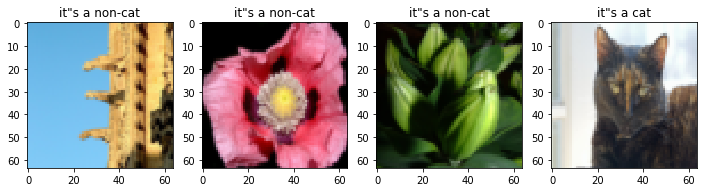

In [4]:
#ome random images and labels
plt.subplots(figsize=(12,12))
col = 4
row = 1

for i in range(1, col*row +1):
    plt.subplot(row, col, i)
    idx = np.random.randint(0, len(train_set_x_orig))
    plt.imshow(train_set_x_orig[idx])
    plt.title('it"s a ' + classes[np.squeeze(train_set_y_orig[:,idx])].decode('utf-8'))
    
plt.show()
    

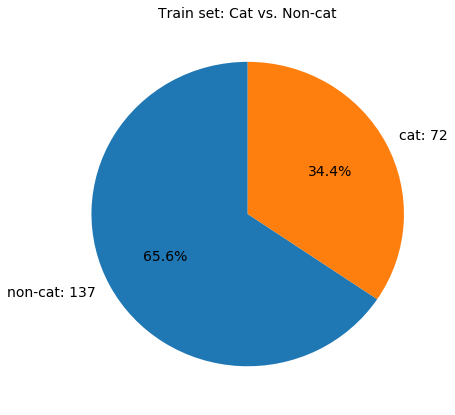

In [5]:
# Visualize the train set labels
plt.figure(figsize=(7,7))
unique, counts = np.unique(train_set_y_orig, return_counts=True)
plt.pie(x=counts, labels =['non-cat: %s' % counts[0], 'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle =90, textprops={'fontsize':14})
plt.title('Train set: Cat vs. Non-cat', fontdict={'fontsize': 14})
plt.show()

In [6]:
# Convert X to 2D array
X_train = train_set_x_orig.flatten().reshape(len(train_set_x_orig),-1) / 255
X_test = test_set_x_orig.flatten().reshape(len(test_set_x_orig),-1) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1,-1)
y_test = test_set_y_orig.reshape(1,-1)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((209, 12288), (1, 209), (50, 12288), (1, 50))

## Building model from scratch

![](https://i.imgur.com/ivhZhmx.png)

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).
    
The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_params`, you should make sure that your dimensions match between each layer. Given $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

| |**Shape of W**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |**Shape of b**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Shape of Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:-|:-|:-|:-|:-|
|**Layer 1**|$(n^{[1]},12288)$|$(n^{[1]},1)$|$Z^{[1]} = W^{[1]}  X + b^{[1]} $|$(n^{[1]},209)$|
| **Layer 2**|$(n^{[2]}, n^{[1]})$|$(n^{[2]},1)$|$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$|$(n^{[2]}, 209)$|
|$\vdots$| $\vdots$ | $\vdots$|$\vdots$|$\vdots$|
|**Layer L-1** | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$|
|**Layer L** | $(n^{[L]}, n^{[L-1]})$ | $(n^{[L]}, 1)$|  $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$|$(n^{[L]}, 209)$ |

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

**Mathematical expression of the algorithm**:

![](https://i.imgur.com/FPjpVDX.png)

**Foward propagation:**

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

where $A^{[0]} = X^T$. And the activation functions:

$$A = RELU(Z) = max(0, Z)$$
$$A^{[L]} = sigmoid(Z^{[L]})$$

In [8]:
def sigmoid(Z):
    '''Implement the sigmoid function'''
    return 1./(1 + np.exp(-Z))

In [9]:
def relu(Z):
    '''Implement the relu function'''
    return np.maximum(0, Z)

In [10]:
def relu_backward(Z):
    '''Derivative of the relu function'''
    temp = np.ones(Z.shape)
    temp[Z < 0] = 0
    
    return temp

In [11]:
def layer_sizes( X, Y, hidden_layers):
    '''Create a list of number of nodes in each layers including Input and Output layers

    Arguments:
        X, Y: training data
        hidden_layers: a list of number of nodes in hidden layers

    Example:
    >>> X.shape, Y.shape
    (209, 12288), (1, 209)
    >>> layer_sizes(X_train, y_train, [20, 5, 7])
    array([12288,    20,     5,     7,     1])
    '''
        
    layers_dims = np.array(hidden_layers, copy=True)
    n_x = X.shape[1]
    n_y = Y.shape[0]
    layers_dims = np.insert(layers_dims, 0, n_x)
    layers_dims = np.append(layers_dims, n_y)

    return layers_dims

In [12]:
layer_sizes(X_train, y_train, [20, 5, 7])

array([12288,    20,     5,     7,     1])

In [13]:
def initialize_params(layer_dims):
    '''Initialize W and b of every layer

    Arguments:
        layer_dims: list of number of nodes in each layers including Input and Output layers
                    Output of layer_sizes() function
    Return:
        parameters: a dictionary that contains the weights and biases of each layer
            parameters['W' + str(i)] defines the weights of the ith layer where Input layer has i=0
            parameters['b' + str(i)] defines the biases of the ith layer
    '''
        
    np.random.seed(102)
    parameters = {}
    
    # Loop through number of layers
    #   Initialize weight and bias at each layer
    #   Write assert to check the shape of each layer
    
    L = len(layer_dims)
    for i in range(1, L):
        parameters['W' + str(i)] = np.random.randn(layer_dims[i],  layer_dims[i-1]) * np.sqrt(1/layer_dims[i-1])
        parameters['b' + str(i)] = np.zeros((layer_dims[i], 1))
        
    return parameters

In [35]:
def forward_propagation(X, parameters):
    '''Implement forward propagation

    Arguments:
        X: training data
        parameters: a dictionary that contains the weights and biases of each layer

    Return:
        A_last: Output of the Output layer
        caches: a dictionary that contains Z and A of each layer
            caches['A' + str(i)] is the output of layer ith
            caches['Z' + str(i)] is the linear combination of input of layer ith
    '''
    
    L = (len(parameters) // 2) + 1
    
    caches = {}
    A_prev = X.T
    # Calculate Zi and Ai of all hidden layers in a for loop
    for i in range (1, L):
        Wi = parameters['W' + str(i)]
        bi = parameters['b' + str(i)]
        
        Zi = np.dot(Wi, A_prev) + bi
        if i < L-1:
            Ai = relu(Zi)
        else: 
        # Calculate Z_last and A_last of Output layer and append into caches
            Ai = sigmoid(Zi)
            A_last = Ai
       
        caches['A' + str(i)] = Ai
        caches['Z' + str(i)] = Zi

        A_prev = Ai
        
    return A_last, caches

In [15]:
def compute_cross_entropy_cost(A_last, Y):
    '''Compute the cross entropy cost'''
    m = Y.shape[1]
    loss = np.multiply(Y, np.log(A_last)) + np.multiply(1-Y, np.log(1-A_last))
    J = -(1/m) * np.sum(loss)
    return J

In [40]:
def backward_propagation(X, Y, parameters, caches):
    '''Implement backward propagation

    Arguments:
        X, Y: training data
        parameters: a dictionary that contains the weights and biases of each layer
        caches: a dictionary that contains Z and A of each layer
    Return:
        grads: gradients of weights and biases at each layer
            grads['dW' + str(i)], grads['db' + str(i)], grads['dZ' + str(i)] are the 
            gradients of W, b, and Z at layer ith
    '''
    # Determine number of instances m
    m = Y.shape[1]
    # Determine number of layers L
    L = (len(parameters) // 2) + 1
    # Create an empty dictionary of grads
    grads = {}
    # Caculale dZ_last, dW_last, db_last of the Output layer
    A_last = caches['A' + str(L-1)]
    A_last_prev = caches['A' + str(L-2)]
    dZ_last = A_last - Y
    dW_last = (1/m) * np.dot(dZ_last, A_last_prev.T)
    dB_last = (1/m) * np.sum(dZ_last, axis=1, keepdims=True)
    grads['dZ' + str(L-1)] = dZ_last
    grads['dW' + str(L-1)] = dW_last
    grads['dB' + str(L-1)] = dB_last

    # Loop backward from L-2 to 0 to calculate dZ, dW, db of each layer
    for i in range(L-2, 0, -1):
        Zi = caches['Z' + str(i)]
        W_next = parameters['W' + str(i+1)]
        dZ_next = grads['dZ' + str(i+1)]
        A_prev  = caches['A' + str(i-1)] if i > 1 else X.T
        
        dZi = np.multiply(np.dot(W_next.T, dZ_next), relu_backward(Zi))
        dWi = (1/m) * np.dot(dZi, A_prev.T)
        dBi = (1/m) * np.sum(dZi, axis=1, keepdims=True)
        
        grads['dZ' + str(i)] = dZi
        grads['dW' + str(i)] = dWi
        grads['dB' + str(i)] = dBi

    return grads
    

In [30]:
def update_pagrams(parameters, grads, learning_rate):
    '''Update the parameters after backward propagation

    Arguments:
        parameters: a dictionary that contains the weights and biases of each layer
        grads: gradients of weights and biases at each layer
        learning_rate: the learning rate
    
    Return:
        The updated parameters
    '''
    L = (len(parameters) // 2) + 1
    for i in range(1, L):
        parameters['W' + str(i)] = parameters['W' + str(i)] - learning_rate * grads['dW' + str(i)]
        parameters['b' + str(i)] = parameters['b' + str(i)] - learning_rate * grads['dB' + str(i)]
     
    return parameters

## Run our DNN neural network 

In [42]:
def dnn_model(X, Y, hidden_layers, iterations, learning_rate):
    '''Implement Deep Neural Network

    Arguments:
        X, Y: training data
        hidden_layers: a list of number of nodes in each hidden layers
        iterations: number of training loop (forward and backward propagation)
        learning_rate: the learning rate

    Return:
        The parameters of the trained model
    '''
    # Initialize the parameters
    layer_dims = layer_sizes(X, Y, hidden_layers)
    parameters = initialize_params(layer_dims)
    costs = []
    
    for i in range(iterations):
        # Foward propagation
        A_last, caches = forward_propagation(X, parameters)
        # Calculate cost
        J = compute_cross_entropy_cost(A_last, Y)
        costs.append(J)
        # Backward propagation
        grads = backward_propagation( X, Y, parameters, caches)
        # Update parameters
        parameters = update_pagrams(parameters, grads, learning_rate)
        # Print the cost every 100th iteration
        if i % 100 ==0:
            print('Iteration %i, Cost: %f' % (i, J))
            
    # plot the cost
    fig, ax = plt.subplots(figsize=(6,8))
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iteration')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show
    
    return parameters

In [46]:
def predict(X, parameters):
    '''Predict class label for samples in X

    Arguments:
        X: the list of sample
        parameters: a dictionary that contains the weights and biases of each layer
    
    Return:
        predictinos: a list of class label
    '''
    
    A_last, cache = forward_propagation(X, parameters)
    predictions = A_last > 0.5
    return predictions

Iteration 0, Cost: 0.688985
Iteration 100, Cost: 0.666225
Iteration 200, Cost: 0.654116
Iteration 300, Cost: 0.649604
Iteration 400, Cost: 0.647459
Iteration 500, Cost: 0.645748
Iteration 600, Cost: 0.644047
Iteration 700, Cost: 0.642279
Iteration 800, Cost: 0.640444
Iteration 900, Cost: 0.638537
Iteration 1000, Cost: 0.636475
Iteration 1100, Cost: 0.634301
Iteration 1200, Cost: 0.631986
Iteration 1300, Cost: 0.629520
Iteration 1400, Cost: 0.626867
Iteration 1500, Cost: 0.624028
Iteration 1600, Cost: 0.620964
Iteration 1700, Cost: 0.617538
Iteration 1800, Cost: 0.613868
Iteration 1900, Cost: 0.609919
Iteration 2000, Cost: 0.605698
Iteration 2100, Cost: 0.601013
Iteration 2200, Cost: 0.595074
Iteration 2300, Cost: 0.588649
Iteration 2400, Cost: 0.581340
Iteration 2500, Cost: 0.572140
Iteration 2600, Cost: 0.560637
Iteration 2700, Cost: 0.549839
Iteration 2800, Cost: 0.538708
Iteration 2900, Cost: 0.526756
Iteration 3000, Cost: 0.514093
Iteration 3100, Cost: 0.501820
Iteration 3200, Cost

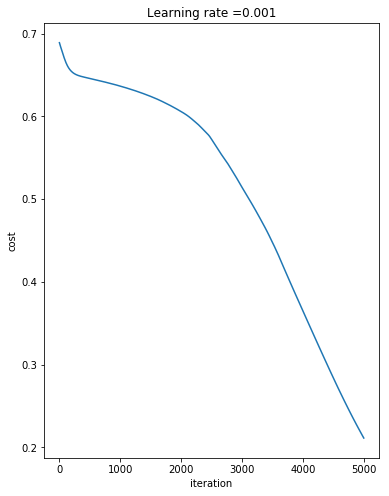

In [65]:
parameters = dnn_model(X_train, y_train, hidden_layers=[20, 5, 7], iterations=5000, learning_rate=0.001)


In [91]:
predictions = predict(X_train, parameters)
print("Accuracy Score - Training set: %f" % accuracy_score(y_train[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_train[0], predictions[0]))
    

Accuracy Score - Training set: 0.961722
Confusion Matrix:
[[133   4]
 [  4  68]]


In [92]:
predictions = predict(X_test, parameters)
print("Accuracy Score - Training set: %f" % accuracy_score(y_test[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], predictions[0]))
    

Accuracy Score - Training set: 0.740000
Confusion Matrix:
[[12  5]
 [ 8 25]]


In [93]:
predictions[0]

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False, False,  True, False, False,  True,  True,  True, False,
       False, False,  True, False,  True,  True, False,  True, False,
       False,  True, False, False,  True,  True,  True, False,  True,
       False, False,  True,  True, False])

In [94]:
a = y_test + predictions
mislabeled_indices = np.asarray(np.where(a == 1))
mislabeled_indices[1]

array([ 5,  6, 13, 18, 19, 26, 28, 29, 30, 33, 34, 44, 46])

In [99]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (50.0, 50.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X[index, :].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

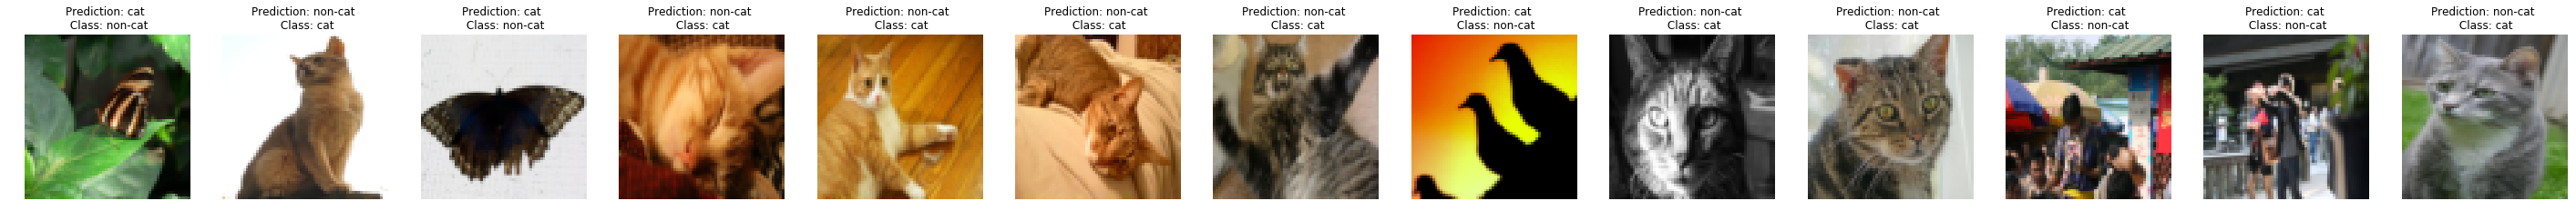

In [100]:
print_mislabeled_images(classes, X_test, y_test, predictions)

## Conclusion